In [1]:
import sys
import json
import nltk
import re
from collections import Counter
import string
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from nltk import bigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
from tqdm.notebook import tqdm
import numpy as np
import math
import statistics
%load_ext autoreload
%autoreload 1
import re 
# we are importing RedditProcessing.py and its contents
%aimport RedditProcessing
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.corpus import words

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thorpanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thorpanda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/thorpanda/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thorpanda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
yt_odi = pd.read_csv("../../Data/Raw/ODI_youtube_comments_all.csv")

In [3]:
yt_odi.head()

,video_id,comment_id,author,published_at,like_count,text,public
0,VQpTVVsNHQs,Ugyg4bUKfvIHL3vy5PR4AaABAg,@athulkrishna1785,2024-10-13T05:17:46Z,1,Maxwell in t20wc 💀🗿\nMaxwell in rcb 🤡☺️😭,True
1,VQpTVVsNHQs,UgyapSuEgdu-lwwdLnp4AaABAg,@MuktharK-u8g,2024-10-12T19:15:16Z,0,2\n\n7a,True
2,VQpTVVsNHQs,UgxdKI2pX0_hYoUdB9t4AaABAg,@aliarsal4082,2024-10-12T15:53:39Z,0,Thank God I watched this match live ball by ba...,True
3,VQpTVVsNHQs,Ugy8d8EsPlG2JgtqIwh4AaABAg,@onedirection3120,2024-10-12T12:09:17Z,0,Slap on Ajay Jadeja face who was mocking his l...,True
4,VQpTVVsNHQs,UgzLAwV1TEmCffWBPyB4AaABAg,@RaviSharen-q1r,2024-10-12T11:37:25Z,0,Aussies mindset☠️,True


In [4]:
# defining a function to tokenize data
def data_tokenizer(text, tokenizer):

    token_list = tokenizer.tokenize(text)
    token_list = [token.strip() for token in token_list]

    return token_list

In [5]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [6]:
def lower_case(text):
    return text.lower()

In [7]:
def tokenizer_remove_spae(text,tokenizer):
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    return lTokens

In [8]:
def filter_words(tokens):
    pos_tags = pos_tag(tokens)
    filtered_words = []
    for token, tag in zip(tokens, pos_tags):
        # Check if the word is in the English dictionary or if it is a noun
        if token.lower() in english_words or (tag[1] == 'NN' or tag[1] == 'NNS'):  # 'NN' and 'NNS' are noun tags
            filtered_words.append(token)
    return filtered_words

In [9]:
def processText(text, tokenizer, stemmer, stopwords):
    """
    Perform tokenisation, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """

    # covert all to lower case
    text = text.lower()
    text = text.replace('\n\n', ' ') 
    text = re.sub(r"http\S+",' ', text)   #remove urls

    text=re.sub(r"\@\S+",' ',text)   #remove username
    
    text=re.sub(r'[^\w\s]','', text)  #remove punctuations
    
    text=re.sub('\d',' ',text ) #remove numbers as words 
    
    text=re.sub(' +',' ',text)  #Merge multiple spaces into one
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    #remove non-english
    
    # remove stopwords, digits
    stop_wordsrmv = [tok for tok in lTokens if tok not in stopwords and not tok.isdigit()]
    # stem (we use set to remove duplicates)
    lStemmedTokens = set([stemmer.stem(tok) for tok in stop_wordsrmv])
    return lStemmedTokens

<>:22: DeprecationWarning: invalid escape sequence '\d'
<>:22: DeprecationWarning: invalid escape sequence '\d'
/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/1986752055.py:22: DeprecationWarning: invalid escape sequence '\d'
  text=re.sub('\d',' ',text ) #remove numbers as words


In [10]:
# tweet to use
postTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['via']
# we use the popular Porter stemmer
postStemmer = nltk.stem.PorterStemmer()

In [11]:
#test
test=yt_odi.copy()

In [12]:
termFreqCounter = Counter()
freqNum = 30

In [13]:
processed_title = []
processed_content = []
for i,row in test.iterrows():
    all_content = str(row["text"])
    process_body = processText(text=all_content, tokenizer=postTokeniser, stemmer=postStemmer, stopwords=lStopwords)
    processed_content.append(' '.join(process_body))
    termFreqCounter.update(process_body)

#test["processed_title"] =processed_title
test["Processed_1"] = processed_content


In [14]:
# defining a pre-processor for vader
def vader_pre_processor(text):
    tokens = postTokeniser.tokenize(text)

    # removing digits
    digit_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    # removing links
    link_pattern = re.compile(r'^http.*|.*\.com|^www.*')

    # filtering tokens
    tokens = [token.strip() for token in tokens if digit_pattern.match(token)==None and link_pattern.match(token)==None and token.strip()]

    # joining tokens togeter
    text = ' '.join(tokens)

    return text

In [15]:
#apply vader preprocessing
vader_tokens = []

for i,row in test.iterrows():
    body = str(row['text'])
    temp_tokens = vader_pre_processor(body)
    vader_tokens.append(temp_tokens)

In [16]:
test.loc[:, 'Processed_2'] = vader_tokens

In [17]:
test.head()

,video_id,comment_id,author,published_at,like_count,text,public,Processed_1,Processed_2
0,VQpTVVsNHQs,Ugyg4bUKfvIHL3vy5PR4AaABAg,@athulkrishna1785,2024-10-13T05:17:46Z,1,Maxwell in t20wc 💀🗿\nMaxwell in rcb 🤡☺️😭,True,rcb maxwel wc,Maxwell in t20wc 💀 🗿 Maxwell in rcb 🤡 ☺ ️ 😭
1,VQpTVVsNHQs,UgyapSuEgdu-lwwdLnp4AaABAg,@MuktharK-u8g,2024-10-12T19:15:16Z,0,2\n\n7a,True,,7a
2,VQpTVVsNHQs,UgxdKI2pX0_hYoUdB9t4AaABAg,@aliarsal4082,2024-10-12T15:53:39Z,0,Thank God I watched this match live ball by ba...,True,watch match ball great experi god thank live,Thank God I watched this match live ball by ba...
3,VQpTVVsNHQs,Ugy8d8EsPlG2JgtqIwh4AaABAg,@onedirection3120,2024-10-12T12:09:17Z,0,Slap on Ajay Jadeja face who was mocking his l...,True,leg jadeja mock face injuri ajay slap,Slap on Ajay Jadeja face who was mocking his l...
4,VQpTVVsNHQs,UgzLAwV1TEmCffWBPyB4AaABAg,@RaviSharen-q1r,2024-10-12T11:37:25Z,0,Aussies mindset☠️,True,mindset aussi,Aussies mindset ☠ ️


In [18]:
test.head()


,video_id,comment_id,author,published_at,like_count,text,public,Processed_1,Processed_2
0,VQpTVVsNHQs,Ugyg4bUKfvIHL3vy5PR4AaABAg,@athulkrishna1785,2024-10-13T05:17:46Z,1,Maxwell in t20wc 💀🗿\nMaxwell in rcb 🤡☺️😭,True,rcb maxwel wc,Maxwell in t20wc 💀 🗿 Maxwell in rcb 🤡 ☺ ️ 😭
1,VQpTVVsNHQs,UgyapSuEgdu-lwwdLnp4AaABAg,@MuktharK-u8g,2024-10-12T19:15:16Z,0,2\n\n7a,True,,7a
2,VQpTVVsNHQs,UgxdKI2pX0_hYoUdB9t4AaABAg,@aliarsal4082,2024-10-12T15:53:39Z,0,Thank God I watched this match live ball by ba...,True,watch match ball great experi god thank live,Thank God I watched this match live ball by ba...
3,VQpTVVsNHQs,Ugy8d8EsPlG2JgtqIwh4AaABAg,@onedirection3120,2024-10-12T12:09:17Z,0,Slap on Ajay Jadeja face who was mocking his l...,True,leg jadeja mock face injuri ajay slap,Slap on Ajay Jadeja face who was mocking his l...
4,VQpTVVsNHQs,UgzLAwV1TEmCffWBPyB4AaABAg,@RaviSharen-q1r,2024-10-12T11:37:25Z,0,Aussies mindset☠️,True,mindset aussi,Aussies mindset ☠ ️


In [19]:
test.to_csv("YT-ODI-final.csv")

In [20]:
# print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))

india: 11341
world: 7640
cup: 7050
team: 6413
match: 6282
final: 5300
catch: 4854
cricket: 4803
hai: 4691
australia: 4543
rohit: 4440
win: 4313
indian: 4266
best: 4189
icc: 4164
like: 3375
love: 3336
play: 3287
one: 3187
time: 3091
pakistan: 2946
wc: 2934
ka: 2815
player: 2575
kohli: 2434
ko: 2326
sharma: 2237
ke: 2167
ball: 2159
bhai: 2141


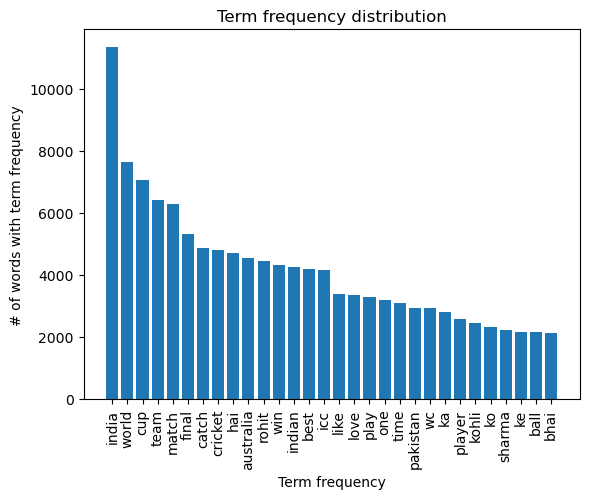

In [21]:
#term freq unigram
# construct the x and y values
y = [count for tag, count in termFreqCounter.most_common(freqNum)]
x = [tag for tag, count in termFreqCounter.most_common(freqNum)]

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution")
plt.ylabel('# of words with term frequency')
plt.xlabel('Term frequency')
plt.xticks(rotation=90)

plt.show()

In [22]:
test["created_date"] = pd.to_datetime(test["published_at"])

In [23]:
test

,video_id,comment_id,author,published_at,like_count,text,public,Processed_1,Processed_2,created_date
0,VQpTVVsNHQs,Ugyg4bUKfvIHL3vy5PR4AaABAg,@athulkrishna1785,2024-10-13T05:17:46Z,1,Maxwell in t20wc 💀🗿\nMaxwell in rcb 🤡☺️😭,True,rcb maxwel wc,Maxwell in t20wc 💀 🗿 Maxwell in rcb 🤡 ☺ ️ 😭,2024-10-13 05:17:46+00:00
1,VQpTVVsNHQs,UgyapSuEgdu-lwwdLnp4AaABAg,@MuktharK-u8g,2024-10-12T19:15:16Z,0,2\n\n7a,True,,7a,2024-10-12 19:15:16+00:00
2,VQpTVVsNHQs,UgxdKI2pX0_hYoUdB9t4AaABAg,@aliarsal4082,2024-10-12T15:53:39Z,0,Thank God I watched this match live ball by ba...,True,watch match ball great experi god thank live,Thank God I watched this match live ball by ba...,2024-10-12 15:53:39+00:00
3,VQpTVVsNHQs,Ugy8d8EsPlG2JgtqIwh4AaABAg,@onedirection3120,2024-10-12T12:09:17Z,0,Slap on Ajay Jadeja face who was mocking his l...,True,leg jadeja mock face injuri ajay slap,Slap on Ajay Jadeja face who was mocking his l...,2024-10-12 12:09:17+00:00
4,VQpTVVsNHQs,UgzLAwV1TEmCffWBPyB4AaABAg,@RaviSharen-q1r,2024-10-12T11:37:25Z,0,Aussies mindset☠️,True,mindset aussi,Aussies mindset ☠ ️,2024-10-12 11:37:25+00:00
...,...,...,...,...,...,...,...,...,...,...
112759,GecN5krG7DA,Ugx0NkM107P6hLIluOt4AaABAg,@SatisfactionFactoryOfficial,2024-09-10T09:15:03Z,3,Pakistan 🇵🇰,True,pakistan,Pakistan 🇵🇰,2024-09-10 09:15:03+00:00
112760,GecN5krG7DA,UgyDzaOO4dziwDg0_OF4AaABAg,@Quickedits-v6i,2024-09-09T10:14:49Z,2,Love from 🇮🇳,True,love,Love from 🇮🇳,2024-09-09 10:14:49+00:00
112761,GecN5krG7DA,UgwclaZaR3StrgznsZh4AaABAg,@Ayushtripathi-t5q,2024-09-09T07:45:41Z,2,India 🇮🇳🇮🇳🇮🇳,True,india,India 🇮🇳 🇮🇳 🇮🇳,2024-09-09 07:45:41+00:00
112762,GecN5krG7DA,UgxPae42A-eOgBLAe4J4AaABAg,@aaravgupta7215,2024-09-09T06:54:54Z,0,Hi,True,hi,Hi,2024-09-09 06:54:54+00:00


In [24]:
test["created_date"]

0        2024-10-13 05:17:46+00:00
1        2024-10-12 19:15:16+00:00
2        2024-10-12 15:53:39+00:00
3        2024-10-12 12:09:17+00:00
4        2024-10-12 11:37:25+00:00
                    ...           
112759   2024-09-10 09:15:03+00:00
112760   2024-09-09 10:14:49+00:00
112761   2024-09-09 07:45:41+00:00
112762   2024-09-09 06:54:54+00:00
112763   2024-09-09 06:22:55+00:00
Name: created_date, Length: 112764, dtype: datetime64[ns, UTC]

In [25]:
test['D_created_date'] = test['created_date'].dt.strftime('%y-%m')
new = test[['D_created_date','comment_id']].groupby('D_created_date').count().reset_index()
new

,D_created_date,comment_id
0,24-01,6349
1,24-02,16474
2,24-03,8002
3,24-04,9693
4,24-05,8316
5,24-06,31361
6,24-07,19323
7,24-08,4969
8,24-09,5481
9,24-10,2796


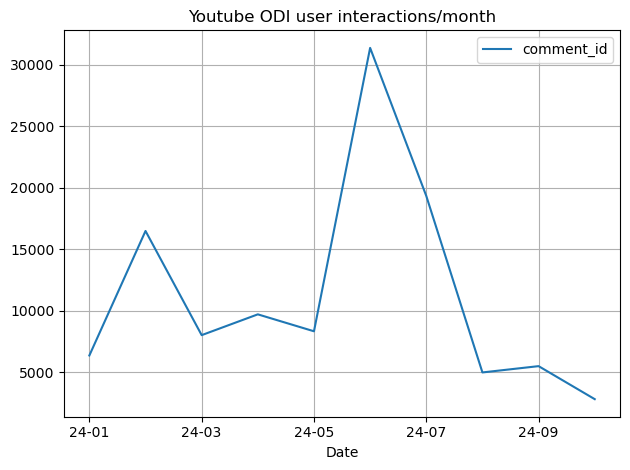

In [48]:

month_c = new[['D_created_date','comment_id']]
# tell pandas that the date column is the one we use for indexing (or x-axis)
month_c.set_index('D_created_date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
month_c['comment_id'] = month_c['comment_id'].apply(pd.to_numeric)
month_c.rename(columns={'post_id': 'count'}, inplace=True)


# this plots and shows the time series
month_c.plot()
plt.title("Youtube ODI user interactions/month")
plt.xlabel("Date")
plt.tight_layout()
plt.grid(True)
plt.show()

In [27]:
month_c

,comment_id
D_created_date,
24-01,6349
24-02,16474
24-03,8002
24-04,9693
24-05,8316
24-06,31361
24-07,19323
24-08,4969
24-09,5481


In [28]:
## sentiment analysis

In [29]:
vader_analyzer = SentimentIntensityAnalyzer()

In [30]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

def vaderSentimentAnalysis(redd_df, bPrint, tweetProcessor):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param redd_df: name of input df containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    # open rows , one by one
    for i,row in redd_df.iterrows():  
            postText = row["Processed_2"]
            
            # pre-process the post text
            lTokens = redditProcessor.process(postText)

            # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
            # see workshop sheet for what dSentimentScores holds
            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

            # save the  sentiment of each post (used for time series)
            lSentiment.append( dSentimentScores['compound'])

    
            #if bPrint:
                #print(row["Processed_2"], dSentimentScores)
                
       
                    
                    
    return lSentiment



In [31]:
from nltk.tokenize import TweetTokenizer

tweetTokenizer = TweetTokenizer()
redditProcessor = RedditProcessing.RedditProcessing(tweetTokenizer, lStopwords)

In [141]:
test = test[(test['Processed_2'].str.len() > 20) & (test['Processed_2'].str.len() < 400)]

In [142]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82883 entries, 0 to 112758
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   video_id         82883 non-null  object             
 1   comment_id       82883 non-null  object             
 2   author           82877 non-null  object             
 3   published_at     82883 non-null  object             
 4   like_count       82883 non-null  int64              
 5   text             82883 non-null  object             
 6   public           82883 non-null  bool               
 7   Processed_1      82883 non-null  object             
 8   Processed_2      82883 non-null  object             
 9   created_date     82883 non-null  datetime64[ns, UTC]
 10  D_created_date   82883 non-null  object             
 11  vadar_sentiment  82883 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(1), object(8)
memory usa

In [143]:
test.head()

,video_id,comment_id,author,published_at,like_count,text,public,Processed_1,Processed_2,created_date,D_created_date,vadar_sentiment
0,VQpTVVsNHQs,Ugyg4bUKfvIHL3vy5PR4AaABAg,@athulkrishna1785,2024-10-13T05:17:46Z,1,Maxwell in t20wc 💀🗿\nMaxwell in rcb 🤡☺️😭,True,rcb maxwel wc,Maxwell in t20wc 💀 🗿 Maxwell in rcb 🤡 ☺ ️ 😭,2024-10-13 05:17:46+00:00,24-10,0.0000
2,VQpTVVsNHQs,UgxdKI2pX0_hYoUdB9t4AaABAg,@aliarsal4082,2024-10-12T15:53:39Z,0,Thank God I watched this match live ball by ba...,True,watch match ball great experi god thank live,Thank God I watched this match live ball by ba...,2024-10-12 15:53:39+00:00,24-10,0.8271
3,VQpTVVsNHQs,Ugy8d8EsPlG2JgtqIwh4AaABAg,@onedirection3120,2024-10-12T12:09:17Z,0,Slap on Ajay Jadeja face who was mocking his l...,True,leg jadeja mock face injuri ajay slap,Slap on Ajay Jadeja face who was mocking his l...,2024-10-12 12:09:17+00:00,24-10,-0.5994
5,VQpTVVsNHQs,UgyQ_eN1WQld9DQzoBd4AaABAg,@SohilKhan-q9l7b,2024-10-12T10:18:17Z,1,English commentary ❤❤❤,True,commentari english,English commentary ❤ ❤ ❤,2024-10-12 10:18:17+00:00,24-10,0.0000
6,VQpTVVsNHQs,Ugyho-sMGQGagMp7CnV4AaABAg,@shaan891,2024-10-12T09:36:52Z,0,Absolutely best every odi innings. No doubt,True,doubt absolut odi inning everi best,Absolutely best every odi innings . No doubt,2024-10-12 09:36:52+00:00,24-10,0.4576


In [144]:
import sweetviz as sv
my_report = sv.analyze(test)
my_report.show_html(filepath="youtube_ODI.html")

/opt/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecate

                                             |      | [  0%]   00:00 -> (? left)

Report youtube_ODI.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [145]:
lSentiment = []
flagPrint = True
lSentiment = vaderSentimentAnalysis(test, flagPrint, redditProcessor)

In [146]:
test["vadar_sentiment"] = lSentiment

In [ ]:
test["created_date"] = test["created_date"].dt.date


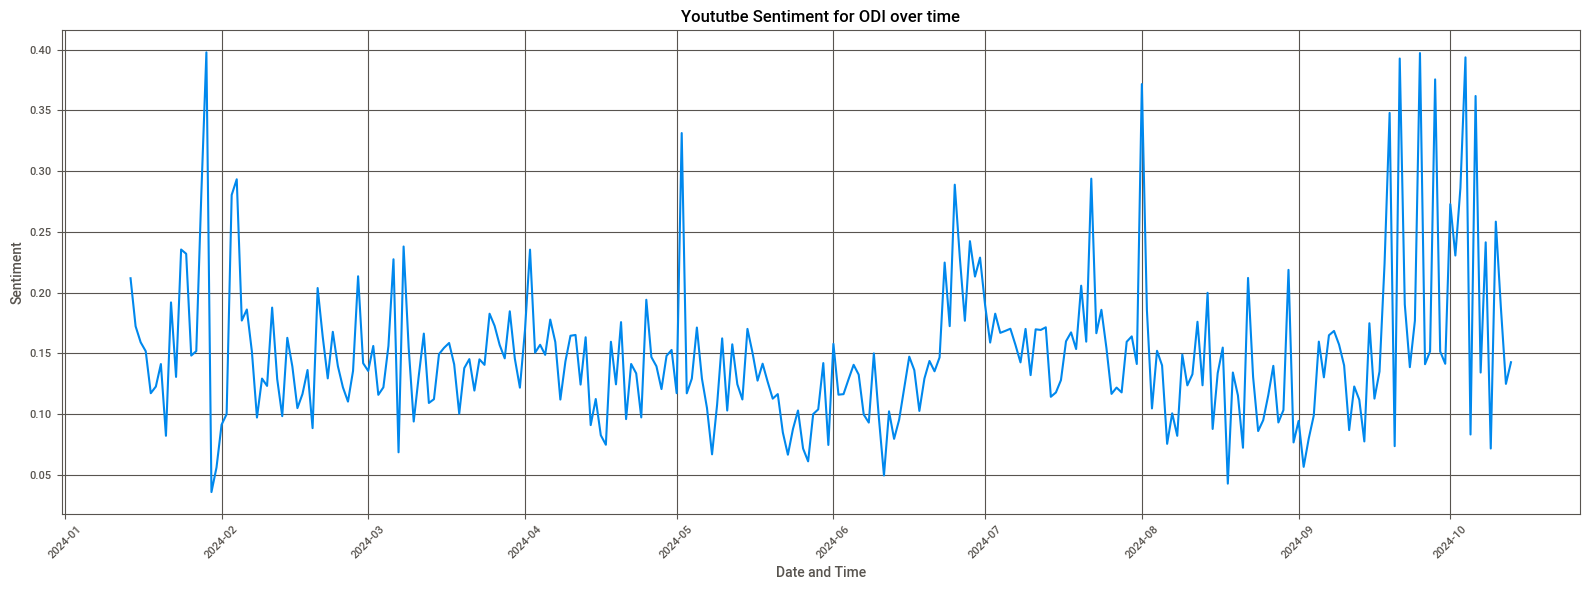

In [151]:
odi_sentiment_aggregated = test.groupby('created_date')['vadar_sentiment'].mean().reset_index()

# plotting sentiment
plt.figure(figsize=(16, 6))
plt.plot(odi_sentiment_aggregated['created_date'],odi_sentiment_aggregated['vadar_sentiment'],linestyle='-')
plt.title('Yoututbe Sentiment for ODI over time')
plt.xlabel('Date and Time')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# topic modeling

In [124]:
comment_text = test['Processed_1'].tolist()

In [125]:
remove_words = ['hai','ko','ki','se','bhi','ki','tha','nahi','ka','nhi','kaha','khatam','kitna']
comment_text = [word for word in comment_text if word not in remove_words]

In [126]:
# creating the count vectorzer object
tfVectorizer = CountVectorizer(max_df=0.95, min_df=80, stop_words='english')
# generating the count vector
tf = tfVectorizer.fit_transform(comment_text)
# list of words in count vector
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [127]:
len(tfFeatureNames)

1057

In [128]:
tfFeatureNames

array(['aa', 'aag', 'aaj', ..., 'हत', 'हम', 'हर'], dtype=object)

In [129]:
#remove = {'hai','ko','ki','se','bhi','ki','tha','nahi','ka','nhi','kaha','khatam','kitna'}
#tfFeatureNames = np.array([item for item in tfFeatureNames if item not in remove])


In [130]:
#LDA tuning
perplexity_scores = []
topics_range = range(2, 10, 1)

for n_topics in topics_range:
    #Train the LDA model for each topic number
    ldaModel = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42)
    ldaModel.fit(tf)
    
    # Compute the perplexity score for the model
    perplexity = ldaModel.perplexity(tf)
    perplexity_scores.append(perplexity)
    
    print(f"Number of topics: {n_topics}, Perplexity: {perplexity}")

#Find the number of topics that minimizes perplexity
best_n_topics = topics_range[np.argmin(perplexity_scores)]
print(f"The best number of topics is: {best_n_topics}")

Number of topics: 2, Perplexity: 460.95612086570685
Number of topics: 3, Perplexity: 449.6373422691659
Number of topics: 4, Perplexity: 465.7723561592024
Number of topics: 5, Perplexity: 505.7550453073719
Number of topics: 6, Perplexity: 580.4472178133138
Number of topics: 7, Perplexity: 585.5797625367566
Number of topics: 8, Perplexity: 589.376335861671
Number of topics: 9, Perplexity: 583.0065071810451
The best number of topics is: 3


In [131]:
best_n_topics = 3
ldaModel = LatentDirichletAllocation(n_components =best_n_topics, max_iter=2, learning_method='online').fit(tf)

In [132]:
#visualize topics
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [133]:
wordNumToDisplay = 15


In [134]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
world cup best win like love play time ball watch match bowl surya bowler cricket
Topic 1:
india team rohit final indian catch pakistan cricket match wc icc kohli congratul australia afghanistan
Topic 2:
hai ka ko ke bhai bhi ki ye se tha nahi hi aur ne ra


In [135]:
# TODO: Add the pyLDAvis code here
# note if you also implemented the word cloud, that will display first, then once you close that
# file, then this will display
# Answer to exercise 2
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [79]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

  
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

In [81]:
#displayWordcloud(ldaModel,tfFeatureNames)

## topic distribution analysis

In [82]:
topics_distribution = ldaModel.transform(tf)

In [83]:
topics_distribution.shape

(83469, 3)

In [84]:
dominant_topic = np.argmax(topics_distribution, axis=1)
#dominant_topic

In [85]:
tfFeatureNames.shape

(1045,)

In [93]:
uniq_topic_com = test[['Processed_1','comment_id']]
uniq_topic_com.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83469 entries, 0 to 112758
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Processed_1  83469 non-null  object
 1   comment_id   83469 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [94]:
uniq_topic_com["topic_id"] = dominant_topic
uniq_topic_com

/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/1710867386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_topic_com["topic_id"] = dominant_topic


,Processed_1,comment_id,topic_id
0,rcb maxwel wc,Ugyg4bUKfvIHL3vy5PR4AaABAg,2
2,watch match ball great experi god thank live,UgxdKI2pX0_hYoUdB9t4AaABAg,0
3,leg jadeja mock face injuri ajay slap,Ugy8d8EsPlG2JgtqIwh4AaABAg,0
5,commentari english,UgyQ_eN1WQld9DQzoBd4AaABAg,0
6,doubt absolut odi inning everi best,Ugyho-sMGQGagMp7CnV4AaABAg,1
...,...,...,...
112750,bhi lomror kiya tha esa yorker kal hi ko,UgwAzLCpfGIH_onnk694AaABAg,2
112751,watch match icc ipl,UgzJ1CODUjKpBS43yft4AaABAg,0
112755,lagat hai ais sab shot,UgzGgBAhp-JLbV9Gkd54AaABAg,2
112757,video time player upload pakistan first icc,Ugzo5r_nZ46hBR1RvRt4AaABAg,0


In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83469 entries, 0 to 112758
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   video_id         83469 non-null  object             
 1   comment_id       83469 non-null  object             
 2   author           83463 non-null  object             
 3   published_at     83469 non-null  object             
 4   like_count       83469 non-null  int64              
 5   text             83469 non-null  object             
 6   public           83469 non-null  bool               
 7   Processed_1      83469 non-null  object             
 8   Processed_2      83469 non-null  object             
 9   created_date     83469 non-null  datetime64[ns, UTC]
 10  D_created_date   83469 non-null  object             
 11  vadar_sentiment  83469 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(1), object(8)
memory usa

In [99]:
comb_tit = pd.merge(test, uniq_topic_com[["Processed_1","topic_id","comment_id"]], on='comment_id', how='left')
comb_tit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83469 entries, 0 to 83468
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   video_id         83469 non-null  object             
 1   comment_id       83469 non-null  object             
 2   author           83463 non-null  object             
 3   published_at     83469 non-null  object             
 4   like_count       83469 non-null  int64              
 5   text             83469 non-null  object             
 6   public           83469 non-null  bool               
 7   Processed_1_x    83469 non-null  object             
 8   Processed_2      83469 non-null  object             
 9   created_date     83469 non-null  datetime64[ns, UTC]
 10  D_created_date   83469 non-null  object             
 11  vadar_sentiment  83469 non-null  float64            
 12  Processed_1_y    83469 non-null  object             
 13  topic_id        

# topic 1

In [114]:
filtered1 = comb_tit[comb_tit["topic_id"]==0]
max_value = filtered1['vadar_sentiment'].max()
content = filtered1["text"][filtered1["vadar_sentiment"]==max_value]
print(content.values[0]) 

Best best best best best best best best best best best best best best best best best best best best best nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice nice 👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍 👍👍👍👍👍👍👍👍👍👍👍👍 INDIA IS GREAT ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤EAST OR WEST INDIA IS THE BEST NICE MOVEMENT OF OUR COUNTRY PEOPLE ❤R❤V❤B❤S❤H❤J❤and all others players best' wishes to all❤❤❤❤❤❤❤❤


In [115]:
max_value = filtered1['vadar_sentiment'].min()
content = filtered1["text"][filtered1["vadar_sentiment"]==max_value]
print(content.values[0]) 

It appalls me that there are so many dumb Indians in the chat here and in other videos that accuse England of cheating in this final.

I have lost count how many stupid Indian fans i have argued with over the past few years calling England cheaters with absolutely no evidence to back it up.

The sad  thing is though that I have never spoken to a single NZ fan, Australian fan, SA fan, West Indian fan, Pakistan fan, Sri Lanka fan, Bangladesh fan or any other cricket fan that accused England of cheating it’s always the dumb Indians.

Maybe they should concentrate more on having a go at their own white ball cricketers than calling out England after all they haven’t won a major ICC trophy in over 10years and make a mockery of the WTC because they flatly refuse to ever play test cricket against Pakistan. (It’s been 17 years now)

The WC is an ICC run tournament and NEVER a locally run cricket board tournament so they make up the rules of the tournament and as far as I know both sides agreed 

/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/4265865160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_v[['vadar_sentiment']] = series_v[['vadar_sentiment']].apply(pd.to_numeric)
/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/4265865160.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vadarSeries = series_v.resample('1H').mean()


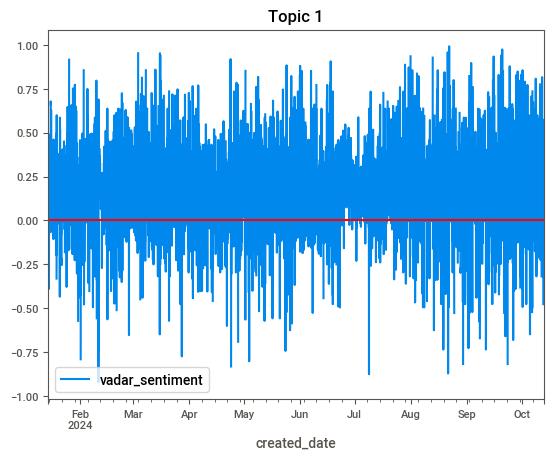

In [116]:
# we are using pandas for this, but first we need to get it into a pandas data frame structure
series_v = filtered1[['created_date','vadar_sentiment']]
# tell pandas that the date column is the one we use for indexing (or x-axis)
series_v.set_index('created_date', inplace=True)

series_v[['vadar_sentiment']] = series_v[['vadar_sentiment']].apply(pd.to_numeric)



vadarSeries = series_v.resample('1H').mean()
# this plots and shows the time series
vadarSeries.plot()
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Topic 1")

plt.show()

## topic 2

In [117]:
filtered1 = comb_tit[comb_tit["topic_id"]==1]
max_value = filtered1['vadar_sentiment'].max()
content = filtered1["text"][filtered1["vadar_sentiment"]==max_value]
print(content.values[0]) 

Congratulations 2 Australia Mens' Seniors National Cricket Team, they are the champions of the 2023 International Cricket Council One Day Internationals World Cup as they win this WC in India. A close final in this match as both sides struggled with the bat but Australia did enuf en they beat the Indians eventually. Tournament sports are hard because u have a few chances 2 play so both sides played well 2 reach the big stage which is the final but you can't measure success u earn this. Maybe u myt have thought the aindians were going 2 be successful en surprise Australia but they lost. Maybe u wud have also predicted Australia wud b dominant and play well like they usually do en maybe put a bet on this match but it wasn't a classic n it's a historic Cricket ODI World Cup final. Australi did a good job at the end so they feel happy they feel gud they won en now this is sum history and a special time now as they celebrate winning another ICC ODI Cricket World Cup. Well done boys, the coa

In [118]:
max_value = filtered1['vadar_sentiment'].min()
content = filtered1["text"][filtered1["vadar_sentiment"]==max_value]
print(content.values[0]) 

India is cheater India is cheating India is cheater India's cheater India's cheater cheater India cheater India cheater 🖕🖕🖕🖕🖕🖕🖕🖕🖕🖕


/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/522533479.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_v[['vadar_sentiment']] = series_v[['vadar_sentiment']].apply(pd.to_numeric)
/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/522533479.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vadarSeries = series_v.resample('1H').mean()


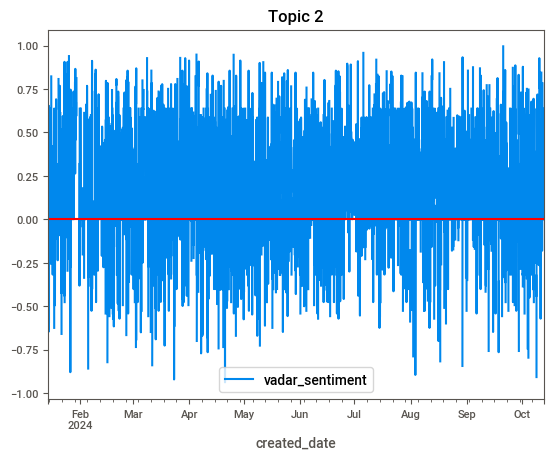

In [119]:
# we are using pandas for this, but first we need to get it into a pandas data frame structure
series_v = filtered1[['created_date','vadar_sentiment']]
# tell pandas that the date column is the one we use for indexing (or x-axis)
series_v.set_index('created_date', inplace=True)

series_v[['vadar_sentiment']] = series_v[['vadar_sentiment']].apply(pd.to_numeric)



vadarSeries = series_v.resample('1H').mean()
# this plots and shows the time series
vadarSeries.plot()
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Topic 2")

plt.show()

## topic 3

In [120]:
filtered1 = comb_tit[comb_tit["topic_id"]==2]
max_value = filtered1['vadar_sentiment'].max()
content = filtered1["text"][filtered1["vadar_sentiment"]==max_value]
print(content.values[0]) 

Match pehle se fix ha india ko world cup dena ha toh ye acting kyo kr rhe ho bhai sb players ko pta ha ki cricket  kaise work krta ha icc khud involved ha isme mera comment pin krdena india world cup jeetegi africa bik jaegi finale ye log duniya ko chutiya bnate ha harte bhi fixing se ha aur jeette bhi fixing se ha 140 ki pitch pe eng ne 170 pitwa diye jo bilkul impossible the moeen ali se bowling nhi krwai butler ne jbki spin track tha rohit sharma ro isliye rha ha kyonki icc ne utne salo tk india ko cup nhi jitwaya kyonki india pe hamesha bhut paisa lgta tha isliye harwa dete ha pr iss baar cup india ko milna ha isliye emotional ho rha aur jo nhi mante cricket me fixing nhi hoti toh captain ki shirt me mic lgwao pta chl jaega ki bowlers ko kya msg deta ha bowling krte waqt duniya bhi toh sune ki kaise ye mens and womens pure cricket lovers ko bewkoof bnate ha dug out sme upar se msg aate ha aage woh drinks boy ke threw playero tk jate ha aaj nhi toh kl inki sachai khulegi jarur kaise

In [121]:
max_value = filtered1['vadar_sentiment'].min()
content = filtered1["text"][filtered1["vadar_sentiment"]==max_value]
print(content.values[0]) 

Aur 2023 wc ghar me hote hue nhi jit pya... To bki wc jeet jyega lgtah ai... Shame on Indian cricket team... Coach ... Selector.......cricket khelne ke layak hi nhi hai indian team.... Ghar me nhi jit pya chii chii chii. 😏😏😏🤬🤬.. Aur cricket fans bhi bss jhuth muth ka crowd lgate hai aur ye log hmehsa disappoint krta hai sab indian fans.....  .. 2014 20 wc final loat 2015 wc sf lost... 2016 t20 wc sf lost. 2017 ct final  lost.2019 wc sf lost.. ... 2021 wtc final lost. 2021 t20 wc group stage lost by pak by 10 wicket..... 2022 wc sf lost... 2023 wtc final lost.... Aur phir 2023 wc final lost also... 🤬🤬🤬🤬🤬🤬  kam se kam ak me to jeet lia hota besharm indian cricket..... Sab me fisadi... Jaisa haal hai phir lgtah ia 2024 wc me bhi sf ya final me harega ye log 😏😏😏😏


/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/3122202422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_v[['vadar_sentiment']] = series_v[['vadar_sentiment']].apply(pd.to_numeric)
/var/folders/6g/7khzkpj52_g5rbfvf4tck4zr0000gn/T/ipykernel_54489/3122202422.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vadarSeries = series_v.resample('1H').mean()


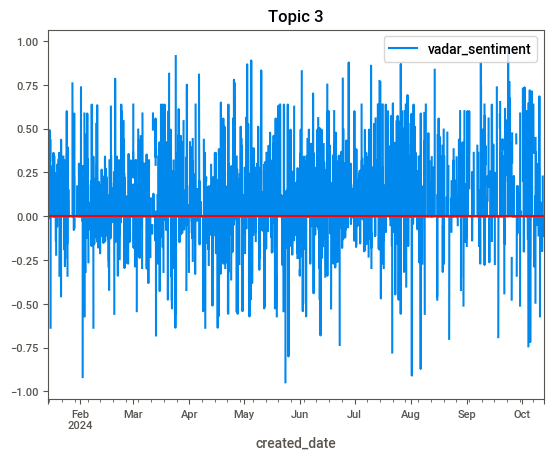

In [122]:
# we are using pandas for this, but first we need to get it into a pandas data frame structure
series_v = filtered1[['created_date','vadar_sentiment']]
# tell pandas that the date column is the one we use for indexing (or x-axis)
series_v.set_index('created_date', inplace=True)

series_v[['vadar_sentiment']] = series_v[['vadar_sentiment']].apply(pd.to_numeric)



vadarSeries = series_v.resample('1H').mean()
# this plots and shows the time series
vadarSeries.plot()
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Topic 3")

plt.show()

In [172]:
df_renamed.head()

,Post_id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2,Count_sentiment,created_date,vadar_sentiment
0,181eyfx,2023-11-23 04:42:32,FondantAggravating68,67,45.0,Hey everyone I did a post on who were the [sta...,Post,baristow ganguli sohail tendulkar tier order h...,Hey everyone I did a post on who were the [ st...,0.9894,2023-11-23 04:42:32,0.9894
1,kadb2o0,2023-11-23 10:34:00,Fidelius_Rex,63,NaN,"Really liking these posts op, but this still d...",Comment,op doesnt post like mwaugh fix still watson re...,"Really liking these posts op , but this still ...",0.4201,2023-11-23 10:34:00,0.4201
2,kadq4v1,2023-11-23 12:25:37,NaN,32,NaN,Crazy that Sachin's strike rate is higher than...,Comment,volum strike huge rate crazi higher run sachin...,Crazy that Sachin's strike rate is higher than...,-0.5943,2023-11-23 12:25:37,-0.5943
3,kaelxd1,2023-11-23 16:46:45,hot-cuppa-chai,14,NaN,Yikes! I didn't know that there was SUCH a big...,Comment,idea srtganguli partnership gap run seri best ...,Yikes ! I didn't know that there was SUCH a bi...,0.7096,2023-11-23 16:46:45,0.7096
4,kad9r8r,2023-11-23 10:24:21,anchorschmidt8,9,NaN,Fantastic,Comment,fantast,Fantastic,0.5574,2023-11-23 10:24:21,0.5574
